# Обучение CNN модели

In [9]:
import numpy as np
import pandas as pd
import os
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
train_data_path = "images/train"
test_data_path = "images/test"

train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

Загрузка сегментатора, который мы обучили в ```finetune_seg.ipynb```

In [5]:
seg_model = YOLO("runs/segment/train/weights/best.pt")

Посмотрим на пример работы модели

In [6]:
example = "images/train/A2miww5mfx/A2miww5mfx_R_028.png"
results = seg_model(example)


image 1/1 d:\python\manioka\images\train\A2miww5mfx\A2miww5mfx_R_028.png: 32x640 6 roots, 179.7ms
Speed: 2.8ms preprocess, 179.7ms inference, 217.6ms postprocess per image at shape (1, 3, 32, 640)


In [8]:
example_image = Image.open(example)
display(example_image)

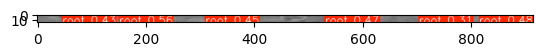

In [10]:
img = results[0].plot()
plt.imshow(img)

Что-то да нашлось :)

### Извлечение сегментов

Теперь нужно подготовить датасет для обучения модели-регрессора. Сперва извлечём сегменты

In [ ]:
def get_segmented_images(model, image_paths, display_image=False):
    """Извлечение детектированных сегментов"""

    results = model(image_paths, verbose=False)


    if len(results[0].boxes.xyxy) == 0:
        # в случае отсутствия детекций
        return [Image.open(img) for img in image_paths]
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        
        # Пропускаем изображения без детекций
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Оставляем сегменты
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            segmented_images.append(segment)
            

    # Отрисовка для демонстрации
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images

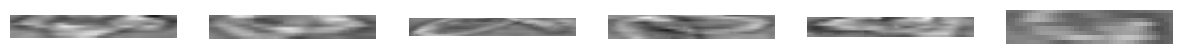

[<PIL.Image.Image image mode=RGBA size=65x9>,
 <PIL.Image.Image image mode=RGBA size=56x8>,
 <PIL.Image.Image image mode=RGBA size=100x11>,
 <PIL.Image.Image image mode=RGBA size=69x10>,
 <PIL.Image.Image image mode=RGBA size=76x9>,
 <PIL.Image.Image image mode=RGBA size=39x8>]

In [36]:
get_segmented_images(seg_model, [example], display_image=True)

### Загрузка серии срезов

In [31]:
def get_images(img_root : str, folder : str, side : str, start : int, end : int) -> list[str]:
    """Получение списка последовательности изображений

    Args:
        img_root (str): корневая папка с изображениями
        folder (str): папка корня
        side (str): (L|R) сторона
        start (int): начальный срез
        end (int): конечный срез

    Returns:
        list[str]: список путей до изображений
    """
    images = []
    for i in range(start, end + 1):
        path = os.path.join(
            img_root,
            folder,
            f"{folder}_{side}_{i:03d}.png"
        )
        if os.path.exists(path):
            images.append(path)

    return images

In [32]:
samples = get_images(train_data_path, folder="A2miww5mfx", side="R", start=28, end=35)
print(samples)

['images/train\\A2miww5mfx\\A2miww5mfx_R_028.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_029.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_030.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_031.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_032.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_033.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_034.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_035.png']


### Компоновка сегментов

In [48]:
def merge_segmented_images(root: str, folder: str, side: str, start: int, end: int) -> Image:
    """Компоновка сегментов по серии срезов

    Args:
        root (str): корневой путь
        folder (str): папка корня
        side (str): (L|R) сторона
        start (int): начальный срез
        end (int): конечный срез

    Returns:
        Image: Итоговое изображение PIL.Image
    """
    images_in_range = get_images(root, folder, side, start, end)
    segmented_images = get_segmented_images(seg_model, images_in_range)

    total_width = sum(img.width for img in segmented_images)
    max_height = max(img.height for img in segmented_images)
    res = Image.new("RGBA", (total_width, max_height * len(segmented_images)), (0, 0, 0, 0))
    sqr_width = int(total_width / max_height)
    
    x_offset = 0
    y_offset = 0
    actual_width = 0
    for segment in segmented_images:
        if x_offset + segment.width > sqr_width:
            actual_width = max(actual_width, x_offset)
            x_offset = 0
            y_offset += max_height
        res.paste(segment, (x_offset, y_offset))
        x_offset += segment.width
    actual_height = y_offset + max_height
    res = res.crop((0, 0, actual_width, actual_height))

    return res

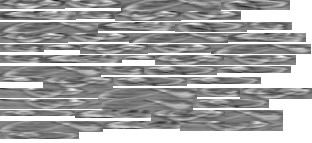

In [49]:
img = merge_segmented_images(train_data_path, folder="A2miww5mfx", side="R", start=28, end=35)
display(img)

Изображения компонуются так, чтобы итоговые пропорции были близки к квадратному изображению

## Датасет для регрессора

Теперь создадим датасет для свёрточного регрессора

In [51]:
output_root = "merged_images"

output_train = os.path.join(output_root, "train")
output_test = os.path.join(output_root, "test")

os.makedirs(output_train, exist_ok=True)
os.makedirs(output_test, exist_ok=True)